# Isolation Forest Outlier Detection

- Features to add: Time of day, laser strength, long, lat, solar elev., azimuth ...
- Assemble a massive file with all the data; each row is a shot
- Use more files from GDrive, get 1000 files
- Do a PCA on the massive file (exploratory data analysis)
- Probably 1 or 2 RH metrics are enough for RH
- Instrumentation data may work too
- For clustering to work, we need to know where each cluster is -- we're really modeling the covariance matrices
- "Given this set of data, can this point be drawn from this cov matrix?"
- Look at cov within consecutive shots
- Learn from different passes at different times (how?)
- Idea: being aware of context

In [1]:
import os
import random

import h5py
import numpy as np
import pandas as pd
import geopandas as gp

import matplotlib
import matplotlib.pyplot as plt

# To dos:
- Beam & channel are relevant
- Exclude RH's in PCA
- Want meta-data, not data per se
- SHAP after ML output
- Google Earth Engine

1/14 Meeting
- Get rid of things that are not useful
- There are definitely not 200,000 unique features
- Everything is x7
- Use the selected algorithm
- should be in hundreds
- Num of PCA components should be determined by amount of explained variance
- Keep in mind that PCA may not necessary be best

In [2]:
'''Importing original input'''
raw_df = pd.read_parquet('input_raw.parquet', engine='pyarrow')
raw_df

,File Name,Beam Name,Shot Number,RH_25,RH_50,RH_75,RH_85,RH_95,RH_100,channel,...,zcross_localenergy,RH_25 Z Score,RH_50 Z Score,RH_75 Z Score,RH_85 Z Score,RH_95 Z Score,RH_100 Z Score,RH_50_v_100,RH_95_minus_50,Missingness
0,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050304,-0.78,0.00,0.78,1.19,1.79,2.36,0,...,163.479019,-0.267243,-0.224966,-0.212232,-0.213468,-0.214492,-0.240572,0.000000,1.79,0
1,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050305,-0.97,-0.07,0.78,1.23,1.87,2.54,0,...,178.583328,-0.352941,-0.243600,-0.212232,-0.206578,-0.202634,-0.216597,-0.027559,1.94,0
2,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050306,-0.86,-0.07,0.71,1.12,1.72,2.32,0,...,203.563889,-0.303326,-0.243600,-0.225654,-0.225526,-0.224867,-0.245900,-0.030172,1.79,0
3,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050307,-0.86,-0.07,0.74,1.16,1.79,2.47,0,...,221.641510,-0.303326,-0.243600,-0.219902,-0.218636,-0.214492,-0.225921,-0.028340,1.86,0
4,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM0000,20820000200050308,-0.89,-0.03,0.78,1.23,1.94,2.73,0,...,268.898804,-0.316857,-0.232952,-0.212232,-0.206578,-0.192258,-0.191289,-0.010989,1.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11607182,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293934,-1.23,-0.18,0.74,1.23,2.02,3.70,5,...,2616.521729,-0.470212,-0.272881,-0.219902,-0.206578,-0.180400,-0.062087,-0.048649,2.20,0
11607183,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293935,-1.23,-0.22,0.71,1.16,1.94,3.70,5,...,2879.136963,-0.470212,-0.283529,-0.225654,-0.218636,-0.192258,-0.062087,-0.059459,2.16,0
11607184,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293936,-1.27,-0.22,0.74,1.23,2.02,3.85,5,...,2619.544189,-0.488253,-0.283529,-0.219902,-0.206578,-0.180400,-0.042108,-0.057143,2.24,0
11607185,/oscar/scratch/jzhu118/GEDI_Outlier_Detection_...,BEAM1011,224961100200293937,-1.16,-0.14,0.78,1.27,2.05,3.81,5,...,2381.172363,-0.438639,-0.262233,-0.212232,-0.199688,-0.175953,-0.047435,-0.036745,2.19,0


In [3]:
'''Importing scaled input'''
scaled_df = pd.read_parquet('input_standard_scaled.parquet', engine='pyarrow')
scaled_df

,RH_25,RH_50,RH_75,RH_85,RH_95,RH_100,channel,degrade_flag,delta_time,digital_elevation_model,...,zcross_amp,zcross_localenergy,RH_25 Z Score,RH_50 Z Score,RH_75 Z Score,RH_85 Z Score,RH_95 Z Score,RH_100 Z Score,RH_95_minus_50,Missingness
0,-0.261052,-0.219977,-0.205986,-0.204688,-0.209075,-0.235969,-1.160313,-0.225547,-1.733653,-1.193618,...,0.185156,-0.211920,-0.261052,-0.219977,-0.205986,-0.204688,-0.209075,-0.235969,-0.157817,-0.842991
1,-0.344765,-0.238197,-0.205986,-0.198081,-0.197517,-0.212452,-1.160313,-0.225547,-1.733653,-1.193618,...,0.208783,-0.188663,-0.344765,-0.238197,-0.205986,-0.198081,-0.197517,-0.212452,-0.118490,-0.842991
2,-0.296300,-0.238197,-0.219014,-0.216249,-0.219189,-0.241195,-1.160313,-0.225547,-1.733653,-1.193618,...,0.207195,-0.150200,-0.296300,-0.238197,-0.219014,-0.216249,-0.219189,-0.241195,-0.157817,-0.842991
3,-0.296300,-0.238197,-0.213431,-0.209643,-0.209075,-0.221597,-1.160313,-0.225547,-1.733653,-1.193618,...,0.231784,-0.122365,-0.296300,-0.238197,-0.213431,-0.209643,-0.209075,-0.221597,-0.139465,-0.842991
4,-0.309517,-0.227785,-0.205986,-0.198081,-0.187403,-0.187628,-1.160313,-0.225547,-1.733653,-1.193618,...,0.270389,-0.049602,-0.309517,-0.227785,-0.205986,-0.198081,-0.187403,-0.187628,-0.110624,-0.842991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11607182,-0.459320,-0.266829,-0.213431,-0.198081,-0.175844,-0.060899,1.733180,-0.225547,1.428969,0.836476,...,2.818989,3.565103,-0.459320,-0.266829,-0.213431,-0.198081,-0.175844,-0.060899,-0.050322,-0.842991
11607183,-0.459320,-0.277240,-0.219014,-0.209643,-0.187403,-0.060899,1.733180,-0.225547,1.428969,0.836477,...,2.961269,3.969460,-0.459320,-0.277240,-0.219014,-0.209643,-0.187403,-0.060899,-0.060809,-0.842991
11607184,-0.476943,-0.277240,-0.213431,-0.198081,-0.175844,-0.041302,1.733180,-0.225547,1.428969,0.836477,...,2.844775,3.569757,-0.476943,-0.277240,-0.213431,-0.198081,-0.175844,-0.041302,-0.039835,-0.842991
11607185,-0.428478,-0.256417,-0.205986,-0.191474,-0.171510,-0.046528,1.733180,-0.225547,1.428969,0.836474,...,2.499454,3.202729,-0.428478,-0.256417,-0.205986,-0.191474,-0.171510,-0.046528,-0.052944,-0.842991


In [6]:
'''Importing pca input'''
pca_df = pd.read_parquet('input_pca_standard.parquet', engine='pyarrow')
pca_df

,PC1,PC2,PC3
0,0.612675,-1.263434,3.654106
1,0.781962,-1.388205,3.906933
2,0.406006,-1.190687,3.823710
3,0.785757,-1.413091,3.806223
4,0.930454,-1.483352,3.727255
...,...,...,...
11607182,6.021469,-6.241940,-3.716136
11607183,6.280722,-6.549196,-3.888618
11607184,6.219830,-6.386110,-3.728455
11607185,5.682581,-5.664079,-3.047439


### Isolation Forest

In [7]:
# -----------------------------------------------------------------------------
# Assume:
#   - raw_df is your original DataFrame, containing at least the features 'RH_50' and 'RH_95'.
#   - df is the dataset (e.g., scaled or PCA-transformed) you want to use for training the IsolationForest.
#       (Make sure that df and raw_df share the same index so that predictions can be mapped back.)
# -----------------------------------------------------------------------------

# ---------------------------
# Step 1: Split the data into training and testing sets.
# ---------------------------
'''Train-Dev-Test split'''
from sklearn.model_selection import train_test_split

# Choose to use the original (scaled_df) or PCA (pca_df)
input_df = scaled_df

X_train, X_test = train_test_split(input_df, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape[0]} rows")
# print(f"CV size: {X_cv.shape[0]} rows")
print(f"Test size: {X_test.shape[0]} rows")

Train size: 9285749 rows
Test size: 2321438 rows


In [16]:
from sklearn.ensemble import IsolationForest

# ---------------------------
# Step 2: Build and fit the IsolationForest model.
# ---------------------------
# Relevant hyperparameters:
#   - n_estimators: The number of base estimators (trees) in the ensemble.
#   - contamination: The expected fraction of outliers in the data (e.g., 0.1 means 10% outliers).
#   - max_samples: The number of samples to draw from the data to train each base estimator.
#   - random_state: For reproducibility.
iso_forest = IsolationForest(n_estimators=200, max_samples='auto', # or 'auto'
                             contamination=0.03, random_state=42)
print('Fitting isolation forest...')
iso_forest.fit(X_train)
print('Successfully fit isolation forest!')


Fitting isolation forest...
Successfully fit isolation forest!


In [17]:
# ---------------------------
# Step 3: Predict on the test set and map predictions back to raw_df.
# ---------------------------
# The predict() method returns:
#   +1 for inliers and -1 for outliers.
test_predictions = iso_forest.predict(X_test)

# Create a new column in raw_df to store test predictions.
# Rows not in the test set are left as NaN.
raw_df['Outlier'] = np.nan
raw_df.loc[X_test.index, 'Outlier'] = test_predictions

Done graphing untested
Done graphing inliers
Done graphing outliers


/users/jzhu118/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


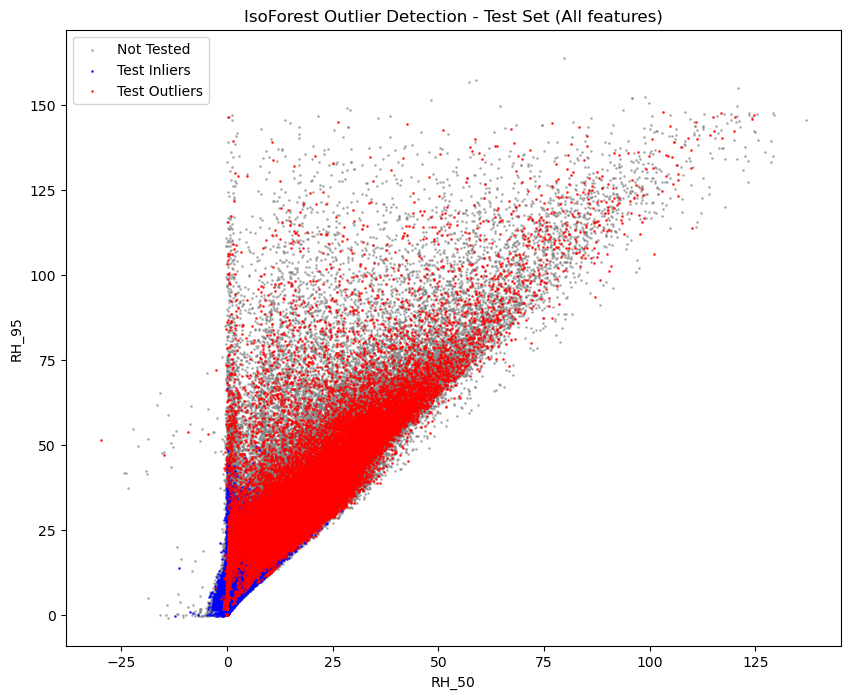

In [18]:
# ---------------------------
# Step 4: Graph the test set predictions on the original raw_df.
# ---------------------------
plt.figure(figsize=(10, 8))

# Optionally, plot the rows that were not part of the test split in grey.
plt.scatter(raw_df.loc[raw_df['Outlier'].isna(), 'RH_50'],
            raw_df.loc[raw_df['Outlier'].isna(), 'RH_95'],
            s = 1,
            c='grey', alpha=0.5, label='Not Tested')
print("Done graphing untested")

# Plot test set inliers (label +1) in blue.
plt.scatter(raw_df.loc[raw_df['Outlier'] == 1, 'RH_50'],
            raw_df.loc[raw_df['Outlier'] == 1, 'RH_95'],
            s = 1,
            c='blue', label='Test Inliers', alpha=0.7)
print("Done graphing inliers")

# Plot test set outliers (label -1) in red.
plt.scatter(raw_df.loc[raw_df['Outlier'] == -1, 'RH_50'],
            raw_df.loc[raw_df['Outlier'] == -1, 'RH_95'],
            s = 1,
            c='red', label='Test Outliers', alpha=0.7)
print("Done graphing outliers")

plt.xlabel('RH_50')
plt.ylabel('RH_95')
plt.title('IsoForest Outlier Detection - Test Set (All features)')
plt.legend()
plt.show()

Generated predictions on entire dataset!
Done graphing inliers
Done graphing outliers


/users/jzhu118/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


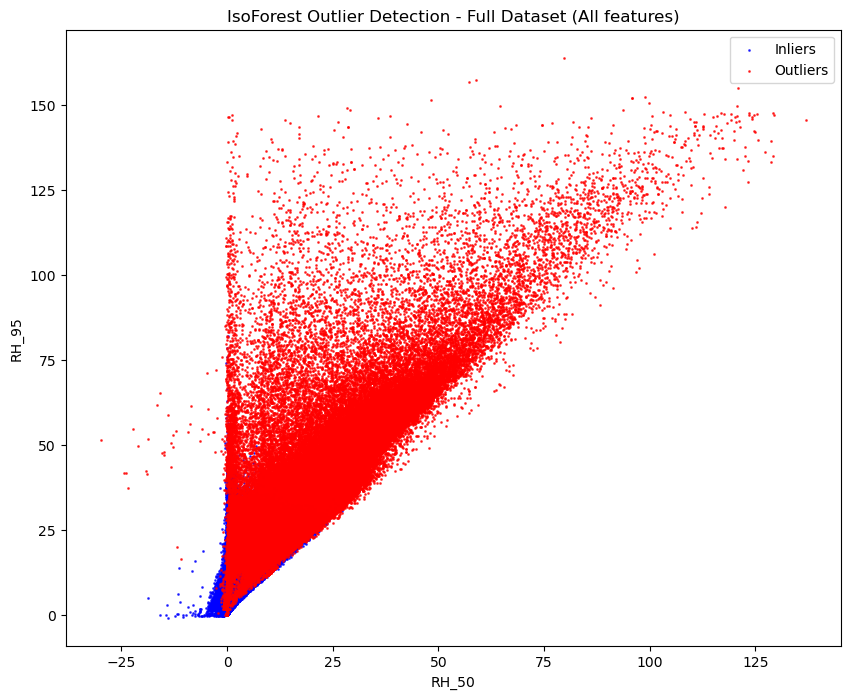

In [21]:
# ---------------------------
# Step 5: Optionally, generate predictions for the entire dataset (train + test) and map them.
# ---------------------------
all_predictions = iso_forest.predict(input_df)
raw_df['Outlier_All'] = all_predictions
print("Generated predictions on entire dataset!")

plt.figure(figsize=(10, 8))

# Plot inliers (label = 1) in blue.
plt.scatter(raw_df.loc[raw_df['Outlier_All'] == 1, 'RH_50'],
            raw_df.loc[raw_df['Outlier_All'] == 1, 'RH_95'],
            s = 1,
            c='blue', label='Inliers', alpha=0.7)
print("Done graphing inliers")

# Plot outliers (label = -1) in red.
plt.scatter(raw_df.loc[raw_df['Outlier_All'] == -1, 'RH_50'],
            raw_df.loc[raw_df['Outlier_All'] == -1, 'RH_95'],
            s = 1,
            c='red', label='Outliers', alpha=0.7)
print("Done graphing outliers")

plt.xlabel('RH_50')
plt.ylabel('RH_95')
plt.title('IsoForest Outlier Detection - Full Dataset (All features)')
plt.legend()
plt.show()

In [ ]:
# ---------------------------
# 3. Visualize the Isolation Forest's Score Ranges in Each PC
# ---------------------------
# import seaborn as sns

# List the features (columns) to evaluate. Here we use 3 PCs.
features_to_plot = ['PC1', 'PC2', 'PC3']

fig, axs = plt.subplots(1, len(features_to_plot), figsize=(18, 6), facecolor='w', edgecolor='k')

for i, column in enumerate(features_to_plot):
    # Fit an Isolation Forest on the 1D data for this column.
    # iso_forest = IsolationForest(contamination='auto', random_state=42)
    data = pca_df[column].values.reshape(-1, 1)
    # iso_forest.fit(data)
    
    # Generate a grid of values across the range of the current column.
    xx = np.linspace(pca_df[column].min(), pca_df[column].max(), 500).reshape(-1, 1)
    # Compute the anomaly (decision) scores for the grid.
    anomaly_score = iso_forest.decision_function(xx)
    # Predict the label (+1 inlier, -1 outlier) for each grid value.
    predictions = iso_forest.predict(xx)
    
    # Plot the decision function (anomaly score).
    axs[i].plot(xx, anomaly_score, label='Anomaly Score', color='b')
    # Highlight the region where the model predicts outliers.
    axs[i].fill_between(xx.ravel(),
                        anomaly_score.min(),
                        anomaly_score.max(),
                        where=(predictions == -1).ravel(),
                        color='r', alpha=0.4, label='Outlier Region')
    axs[i].set_title(column)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [20]:
'''Analytics cell'''

# Choose which prediction to analyze
predictions = test_predictions
df = X_test

# Generate anomaly scores using the decision function.
# More negative values indicate more anomalous observations.
decision_scores = iso_forest.decision_function(df)
print("Generated decision scores")

# Compute the counts and proportions of inliers and outliers.
total_samples = len(predictions)
num_inliers = np.sum(predictions == 1)
num_outliers = np.sum(predictions == -1)
print("Counted all data points")

print("=== Isolation Forest Prediction Analytics ===")
print(f"Total number of samples: {total_samples}")
print(f"Number of inliers: {num_inliers} ({num_inliers/total_samples:.2%})")
print(f"Number of outliers: {num_outliers} ({num_outliers/total_samples:.2%})\n")

# Print summary statistics for the decision function scores.
print("Decision Function Score Statistics:")
print(f"  Minimum score: {np.min(decision_scores):.4f}")
print(f"  Maximum score: {np.max(decision_scores):.4f}")
print(f"  Mean score:    {np.mean(decision_scores):.4f}")
print(f"  Median score:  {np.median(decision_scores):.4f}")
print(f"  Std. dev.:     {np.std(decision_scores):.4f}\n")

# Identify the top 5 most anomalous points (i.e. lowest decision function scores).
# Lower scores indicate more abnormal observations.
anomaly_indices = np.argsort(decision_scores)[:5]  # indices of the 5 lowest scores
most_anomalous = df.iloc[anomaly_indices]

print("Top 5 Most Anomalous Points:")
print(most_anomalous)
print("\nCorresponding Decision Scores:")
# Use df.index to get the corresponding index labels.
for idx in most_anomalous.index:
    print(f"Index {idx}: Score = {decision_scores[df.index.get_loc(idx)]:.4f}")

Generated decision scores
Counted all data points
=== Isolation Forest Prediction Analytics ===
Total number of samples: 2321438
Number of inliers: 2252012 (97.01%)
Number of outliers: 69426 (2.99%)

Decision Function Score Statistics:
  Minimum score: -0.1472
  Maximum score: 0.1745
  Mean score:    0.1089
  Median score:  0.1187
  Std. dev.:     0.0419

Top 5 Most Anomalous Points:
             RH_25      RH_50      RH_75      RH_85      RH_95     RH_100  \
4945701  12.295895  15.342712  15.728694  15.594923  16.215740  17.777917   
4945569  10.577576  11.638798  15.706360  16.653626  16.702647  15.648338   
5065369  10.167823  12.778863  15.198283  15.761739  15.322836  14.614904   
6977262   7.259899   8.429432   8.783094   8.762078   8.431002   7.727089   
5034733   9.141237   8.671501   7.902796   7.610884   7.132100   6.518585   

          channel  degrade_flag  delta_time  digital_elevation_model  ...  \
4945701 -0.002916     -0.225547   -0.416591                 0.836077  ...